# Ex 4: REINFORCE with parametrized policies (20 points)

In this exercise, we will investigate the effect of choosing different baselines in the reinforce implementation.
This topic is covered from Slide 31 on in Lecture 5.

**Hint: You may want to use Google Colab to run the experiments faster, but you don't have to.**

### Import the Necessary Packages

In [ ]:
# TODO: you may need to run this to make sure to have the correct versions
!pip install gym==0.25.2
!pip install gym-notices==0.0.8

In [ ]:
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
torch.manual_seed(0)

import base64, io

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Instantiate the Environment and Agent

The CartPole environment is very simple. It has discrete action space (2) and 4 dimensional state space.

In [ ]:
env = gym.make('CartPole-v0')
env.seed(0)

c:\anaconda\envs\Rlearn\Lib\site-packages\gym\envs\registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
c:\anaconda\envs\Rlearn\Lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\anaconda\envs\Rlearn\Lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\anaconda\envs\Rlearn\Lib\site-packages\gym\core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=

[0]

In [ ]:
class Policy(nn.Module): # definie the policy network
    def __init__(self, state_size=4, action_size=2, hidden_size=32):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = self.fc2(x)
        return F.softmax(x, dim=1) # we just consider 1 dimensional probability of action

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        model = Categorical(probs)
        action = model.sample()
        return action.item(), model.log_prob(action)
    

In [ ]:
# REINFORCE (with reward-to-go)
# --> with gradient estimator according to version 2 of the PG theorem (not using Q-values, but reward to go)
def reinforce_rwd2go(policy, optimizer, early_stop=False, n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    for e in range(1, n_episodes):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        # Collect trajectory
        for t in range(max_t):
            # Sample the action from current policy
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break
        # Calculate total expected reward
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        # Recalculate the total reward applying discounted factor
        discounts = [gamma ** i for i in range(len(rewards) + 1)]
        rewards_to_go = [sum([discounts[j]*rewards[j+t] for j in range(len(rewards)-t) ]) for t in range(len(rewards))]

        # Calculate the loss
        policy_loss = []
        for i in range(len(saved_log_probs)):
            log_prob = saved_log_probs[i]
            G = rewards_to_go[i]
            # Note that we are using Gradient Ascent, not Descent. So we need to calculate it with negative rewards.
            policy_loss.append(-log_prob * G)
        # After that, we concatenate whole policy loss in 0th dimension
        policy_loss = torch.cat(policy_loss).sum()

        # Backpropagation
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if e % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(e, np.mean(scores_deque)))
        if early_stop and np.mean(scores_deque) >= 195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(e - 100, np.mean(scores_deque)))
            break
    return scores

**Question**

1. Find **two** good baselines that improve over the implementation of REINFORCE without baseline. You should plot their results below.

You can take inspiration from the Example Notebook we attached for lecture 4, but you **cannot use exactly the same**.

2. Explain why you chose your baselines and why you think they are reasonable.

*Note:* You may also change other parameters such as the learning rate, as long as you clearly state it in your response.

**Answer**

*Baseline 1* : Average Reward Baseline:

This baseline assumes that the average reward obtained across all states provides a reasonable estimate of the expected return. The idea is that in many environments, especially those where the rewards are relatively consistent for every state, the average reward baseline can reduce the variance in policy gradient estimates. Since the CartPole environment has a simple reward structure (reward of +1 for each time step the pole remains upright), the average reward baseline is a reasonable choice.

*Baseline 2* : Linear Feature Baseline:

Similar to the previous one, this baseline use a a type of weighted average using a linear function of the state features to estimate the expected return. In the CartPole environment, the state consists of four continuous variables: cart position, cart velocity, pole angle, and pole angular velocity. A linear combination of those can allow us to capture a better value, potentially leading to a more accurate estimate than the average reward baseline.


In [ ]:
def naive_baseline(state): # Example Baseline from lecture 4 (for inspiration)
  angle = state[2]
  value = 100*(0.25-angle**2) # TO BE CHANGED USING YOUR BASELINE
  return value

def baseline_1(states):
    return np.mean([np.sum(state) for state in states])

def baseline_2(states):
    # Define weights for linear feature baseline
    weights = np.array([0.5, 0.3, 0.2, 0.1])  # Adjust weights based on feature importance
    return np.dot(states, weights)

# PLOT 3: reward-to-go with baseline REINFORCE
# --> with gradient estimator according to version 3 of the PG theorem (not using Q-values, but reward to go)
# --> here, we consider only fixed (handcrafted) baseline functions b : S -> R; clearly, training a NN to predict V^{\pi}(s) as a baseline is also possible (and interesting!)
def reinforce_rwd2go_baseline(policy, optimizer, early_stop=False, baseline=naive_baseline, n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    for e in range(1, n_episodes):
        saved_log_probs = []
        rewards = []
        baseline_values = []
        state = env.reset()
        # Collect trajectory
        for t in range(max_t):
            # Sample the action from current policy
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            baseline_values.append(baseline(state))
            if done:
                break
        # Calculate total expected reward
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        # Recalculate the total reward applying discounted factor
        discounts = [gamma ** i for i in range(len(rewards) + 1)]
        rewards_to_go = [sum([discounts[j]*rewards[j+t] for j in range(len(rewards)-t) ]) for t in range(len(rewards))]

        # Calculate the loss
        policy_loss = []
        for i in range(len(saved_log_probs)):
            log_prob = saved_log_probs[i]
            G_centered = rewards_to_go[i] - baseline_values[i]
            # Note that we are using Gradient Ascent, not Descent. So we need to calculate it with negative rewards.
            policy_loss.append(-log_prob * G_centered)
        # After that, we concatenate whole policy loss in 0th dimension
        policy_loss = torch.cat(policy_loss).sum()

        # Backpropagation
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if e % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(e, np.mean(scores_deque)))
        if early_stop and np.mean(scores_deque) >= 195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(e - 100, np.mean(scores_deque)))
            break
    return scores

In [ ]:
env = gym.make('CartPole-v0')
env.seed(0)

# PLOT 1: run REINFORCE
policy_rwd2go = Policy().to(device)
optimizer_rwd2go = optim.Adam(policy_rwd2go.parameters(), lr=1e-2)
scores_rwd2go = reinforce_rwd2go(policy_rwd2go, optimizer_rwd2go, early_stop=False, n_episodes=2000)

env = gym.make('CartPole-v0')
env.seed(0)

# PLOT 2: run REINFORCE and YOUR baseline 1
policy_baseline_1 = Policy().to(device)
optimizer_baseline_1 = optim.Adam(policy_baseline_1.parameters(), lr=1e-2)
scores_baseline_1 = reinforce_rwd2go_baseline(policy_baseline_1, optimizer_baseline_1, baseline=baseline_1, early_stop=False, n_episodes=2000)

env = gym.make('CartPole-v0')
env.seed(0)

# PLOT 3: run REINFORCE and YOUR baseline 2
policy_baseline_2 = Policy().to(device)
optimizer_baseline_2 = optim.Adam(policy_baseline_2.parameters(), lr=1e-2)
scores_baseline_2 = reinforce_rwd2go_baseline(policy_baseline_2, optimizer_baseline_2, baseline=baseline_2, early_stop=False, n_episodes=2000)



Episode 100	Average Score: 79.81
Episode 200	Average Score: 163.89
Episode 300	Average Score: 196.95
Episode 400	Average Score: 177.04
Episode 500	Average Score: 195.87
Episode 600	Average Score: 189.74
Episode 700	Average Score: 189.69
Episode 800	Average Score: 200.00
Episode 900	Average Score: 127.43
Episode 1000	Average Score: 19.96
Episode 1100	Average Score: 195.12
Episode 1200	Average Score: 190.84
Episode 1300	Average Score: 177.46
Episode 1400	Average Score: 192.00
Episode 1500	Average Score: 200.00
Episode 1600	Average Score: 200.00
Episode 1700	Average Score: 200.00
Episode 1800	Average Score: 200.00
Episode 1900	Average Score: 200.00
Episode 100	Average Score: 64.23
Episode 200	Average Score: 168.00
Episode 300	Average Score: 175.65
Episode 400	Average Score: 194.33
Episode 500	Average Score: 183.89
Episode 600	Average Score: 197.10
Episode 700	Average Score: 196.02
Episode 800	Average Score: 126.58
Episode 900	Average Score: 168.77
Episode 1000	Average Score: 140.12
Episod

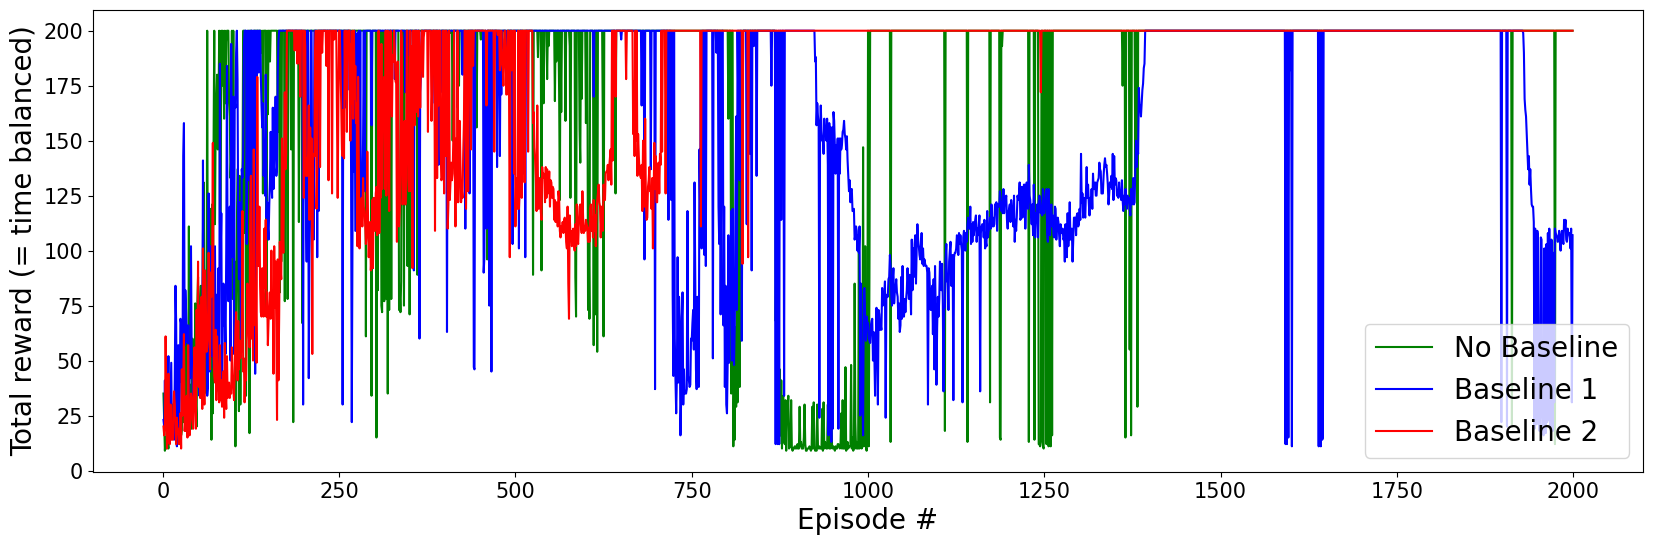

In [ ]:
### Plot the learning progress

# Create the plot
fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot(111)

# Plot the scores with specified colors and labels
ax.plot(np.arange(1, len(scores_rwd2go) + 1), scores_rwd2go, color='green', label='No Baseline')
ax.plot(np.arange(1, len(scores_baseline_1) + 1), scores_baseline_1, color='blue', label='Baseline 1')
ax.plot(np.arange(1, len(scores_baseline_2) + 1), scores_baseline_2, color='red', label='Baseline 2')

# Set the labels with a larger font size
ax.set_ylabel('Total reward (= time balanced)', fontsize=20)
ax.set_xlabel('Episode #', fontsize=20)

# Set the tick labels to a larger font size
ax.tick_params(axis='both', which='major', labelsize=15)

# Add a legend with a specified font size
ax.legend(fontsize=20)

# Show the plot
plt.show()

In [4]:
!pip install wandb

  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
  Using cached protobuf-4.25.3-cp310-abi3-win_amd64.whl.metadata (541 bytes)
  Using cached requests-2.31.0-py3-none-any.whl.metadata (4.6 kB)
  Using cached urllib3-2.2.1-py3-none-any.whl.metadata (6.4 kB)
  Using cached certifi-2024.2.2-py3-none-any.whl.metadata (2.2 kB)
   ---------------------------------------- 0.0/6.7 MB ? eta -:--:--
   - -------------------------------------- 0.3/6.7 MB 5.4 MB/s eta 0:00:02
   --- ------------------------------------ 0.6/6.7 MB 6.3 MB/s eta 0:00:01
   ------ --------------------------------- 1.2/6.7 MB 8.1 MB/s eta 0:00:01
   ---------- ----------------------------- 1.7/6.7 MB 9.9 MB/s eta 0:00:01
   -------------- ------------------------- 2.4/6.7 MB 10.2 MB/s eta 0:00:01
   ----------------- ---------------------- 3.0/6.7 MB 11.2 MB/s eta 0:00:01
   --------------------- ------------------ 3.6/6.7 MB 11.5 MB/s eta 0:00:01
   ------------------------ --------------- 4.1/6.7 MB 11.5 

In [1]:
from argparse import ArgumentParser

import gym
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
from torch.optim import Adam
from torch.optim.lr_scheduler import LinearLR

import wandb

# Definitions
MODEL_PATH = "model.pt"

c:\anaconda\envs\Rlearn\Lib\site-packages\lightning_utilities\core\imports.py:14: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
c:\anaconda\envs\Rlearn\Lib\site-packages\lightning_fabric\__init__.py:41: Deprecated call to `pkg_resources.declare_namespace('lightning_fabric')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
c:\anaconda\envs\Rlearn\Lib\site-packages\pytorch_lightning\__init__.py:37: Deprecated call to `pkg_resources.declare_namespace('pytorch_lightning')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
<frozen importlib._bootstrap>:488: DeprecationWarning:

In [11]:
class MyPPO(nn.Module):
    """Implementation of a PPO model. The same backbone is used to get actor and critic values."""

    def __init__(self, in_shape, n_actions, hidden_d=100, share_backbone=False):
        # Super constructor
        super(MyPPO, self).__init__()

        # Attributes
        self.in_shape = in_shape
        self.n_actions = n_actions
        self.hidden_d = hidden_d
        self.share_backbone = share_backbone

        # Shared backbone for policy and value functions
        in_dim = np.prod(in_shape)

        def to_features():
            return nn.Sequential(
                nn.Flatten(),
                nn.Linear(in_dim, hidden_d),
                nn.ReLU(),
                nn.Linear(hidden_d, hidden_d),
                nn.ReLU(),
            )

        self.backbone = to_features() if self.share_backbone else nn.Identity()

        # State action function
        self.actor = nn.Sequential(
            nn.Identity() if self.share_backbone else to_features(),
            nn.Linear(hidden_d, hidden_d),
            nn.ReLU(),
            nn.Linear(hidden_d, n_actions),
            nn.Softmax(dim=-1),
        )

        # Value function
        self.critic = nn.Sequential(
            nn.Identity() if self.share_backbone else to_features(),
            nn.Linear(hidden_d, hidden_d),
            nn.ReLU(),
            nn.Linear(hidden_d, 1),
        )

    def forward(self, x):
        features = self.backbone(x)
        action = self.actor(features)
        value = self.critic(features)
        return Categorical(action).sample(), action, value


In [34]:
@torch.no_grad()
def run_timestamps(env, model, timestamps=128, render=False, device="cpu"):
    """Runs the given policy on the given environment for the given amount of timestamps.
    Returns a buffer with state action transitions and rewards."""
    buffer = []
    state = env.reset()[0]
    state = np.array(state, dtype=np.float32)
    
    # Running timestamps and collecting state, actions, rewards and terminations
    for ts in range(timestamps):
        # Taking a step into the environment
        model_input = torch.from_numpy(state).unsqueeze(0).to(device).float()
        action, action_logits, value = model(model_input)
        new_state, reward, terminated, truncated, info = env.step(action.item())

        # Rendering / storing (s, a, r, t) in the buffer
        if render:
            env.render()
        else:
            buffer.append(
                [
                    model_input,
                    action,
                    action_logits,
                    value,
                    reward,
                    terminated or truncated,
                ]
            )

        # Updating current state
        state = new_state

        # Resetting environment if episode terminated or truncated
        if terminated or truncated:
            state = env.reset()[0]

    return buffer


In [35]:
def compute_cumulative_rewards(buffer, gamma):
    """Given a buffer with states, policy action logits, rewards and terminations,
    computes the cumulative rewards for each timestamp and substitutes them into the buffer.
    """
    curr_rew = 0.0

    # Traversing the buffer on the reverse direction
    for i in range(len(buffer) - 1, -1, -1):
        r, t = buffer[i][-2], buffer[i][-1]

        if t:
            curr_rew = 0
        else:
            curr_rew = r + gamma * curr_rew

        buffer[i][-2] = curr_rew

    # Getting the average reward before normalizing (for logging and checkpointing)
    avg_rew = np.mean([buffer[i][-2] for i in range(len(buffer))])

    # Normalizing cumulative rewards
    mean = np.mean([buffer[i][-2] for i in range(len(buffer))])
    std = np.std([buffer[i][-2] for i in range(len(buffer))]) + 1e-6
    for i in range(len(buffer)):
        buffer[i][-2] = (buffer[i][-2] - mean) / std

    return avg_rew

In [36]:
def get_losses(model, batch, epsilon, annealing, device="cpu"):
    """Returns the three loss terms for a given model and a given batch and additional parameters"""
    # Getting old data
    n = len(batch)
    states = torch.cat([batch[i][0] for i in range(n)])
    actions = torch.cat([batch[i][1] for i in range(n)]).view(n, 1)
    logits = torch.cat([batch[i][2] for i in range(n)])
    values = torch.cat([batch[i][3] for i in range(n)])
    cumulative_rewards = (
        torch.tensor([batch[i][-2] for i in range(n)]).view(-1, 1).float().to(device)
    )

    # Computing predictions with the new model
    _, new_logits, new_values = model(states)

    # Loss on the state-action-function / actor (L_CLIP)
    advantages = cumulative_rewards - values
    margin = epsilon * annealing
    ratios = new_logits.gather(1, actions) / logits.gather(1, actions)

    l_clip = torch.mean(
        torch.min(
            torch.cat(
                (
                    ratios * advantages,
                    torch.clip(ratios, 1 - margin, 1 + margin) * advantages,
                ),
                dim=1,
            ),
            dim=1,
        ).values
    )

    # Loss on the value-function / critic (L_VF)
    l_vf = torch.mean((cumulative_rewards - new_values) ** 2)

    # Bonus for entropy of the actor
    entropy_bonus = torch.mean(
        torch.sum(-new_logits * (torch.log(new_logits + 1e-5)), dim=1)
    )

    return l_clip, l_vf, entropy_bonus


In [37]:
def training_loop(
    env,
    model,
    max_iterations,
    n_actors,
    horizon,
    gamma,
    epsilon,
    n_epochs,
    batch_size,
    lr,
    c1,
    c2,
    device,
    env_name="namename",
):
    """Train the model on the given environment using multiple actors acting up to n timestamps."""

    # # Starting a new Weights & Biases run
    # wandb.init(
    #     project="Papers Re-implementations",
    #     entity="peutlefaire",
    #     name=f"PPO - {env_name}",
    #     config={
    #         "env": str(env),
    #         "number of actors": n_actors,
    #         "horizon": horizon,
    #         "gamma": gamma,
    #         "epsilon": epsilon,
    #         "epochs": n_epochs,
    #         "batch size": batch_size,
    #         "learning rate": lr,
    #         "c1": c1,
    #         "c2": c2,
    #     },
    # )

    # Training variables
    max_reward = float("-inf")
    optimizer = Adam(model.parameters(), lr=lr, maximize=True)
    scheduler = LinearLR(optimizer, 1, 0, max_iterations * n_epochs)
    anneals = np.linspace(1, 0, max_iterations)

    # Training loop
    for iteration in range(max_iterations):
        buffer = []
        annealing = anneals[iteration]

        # Collecting timestamps for all actors with the current policy
        for actor in range(1, n_actors + 1):
            buffer.extend(run_timestamps(env, model, horizon, False, device))

        # Computing cumulative rewards and shuffling the buffer
        avg_rew = compute_cumulative_rewards(buffer, gamma)
        np.random.shuffle(buffer)

        # Running optimization for a few epochs
        for epoch in range(n_epochs):
            for batch_idx in range(len(buffer) // batch_size):
                # Getting batch for this buffer
                start = batch_size * batch_idx
                end = start + batch_size if start + batch_size < len(buffer) else -1
                batch = buffer[start:end]

                # Zero-ing optimizers gradients
                optimizer.zero_grad()

                # Getting the losses
                l_clip, l_vf, entropy_bonus = get_losses(
                    model, batch, epsilon, annealing, device
                )

                # Computing total loss and back-propagating it
                loss = l_clip - c1 * l_vf + c2 * entropy_bonus
                loss.backward()

                # Optimizing
                optimizer.step()
            scheduler.step()

        # Logging information to stdout
        curr_loss = loss.item()
        log = (
            f"Iteration {iteration + 1} / {max_iterations}: "
            f"Average Reward: {avg_rew:.2f}\t"
            f"Loss: {curr_loss:.3f} "
            f"(L_CLIP: {l_clip.item():.1f} | L_VF: {l_vf.item():.1f} | L_bonus: {entropy_bonus.item():.1f})"
        )
        if avg_rew > max_reward:
            torch.save(model.state_dict(), MODEL_PATH)
            max_reward = avg_rew
            log += " --> Stored model with highest average reward"
        print(log)

        # Logging information to W&B
    #     wandb.log(
    #         {
    #             "loss (total)": curr_loss,
    #             "loss (clip)": l_clip.item(),
    #             "loss (vf)": l_vf.item(),
    #             "loss (entropy bonus)": entropy_bonus.item(),
    #             "average reward": avg_rew,
    #         }
    #     )

    # # Finishing W&B session
    # wandb.finish()

In [38]:
def testing_loop(env, model, n_episodes, device):
    """Runs the learned policy on the environment for n episodes"""
    for _ in range(n_episodes):
        run_timestamps(env, model, timestamps=128, render=True, device=device)

In [39]:
def get_device():
    """Gets the device (GPU if any) and logs the type"""
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"Found GPU device: {torch.cuda.get_device_name(device)}")
    else:
        device = torch.device("cpu")
        print("No GPU found: Running on CPU")
    return device

In [43]:
# Parsing program arguments
# args = parse_args()
# print(args)
args = {}
args["seed"] = 1
args["max_iterations"] = 100
args["n_actors"] = 4
args["horizon"] = 128
args["gamma"] = 0.99
args["epsilon"] = 0.1
args["n_epochs"] = 4
args["batch_size"] = 32*8
args["lr"] = 2.5 * 1e-4
args["c1"] = 1
args["c2"] = 0.01
args["n_test_episodes"] = 5

# Setting seed
pl.seed_everything(args["seed"])

# Getting device
device = get_device()

# Creating environment (discrete action space)
env_name = "CartPole-v1"
env = gym.make(env_name)

# Creating the model (both actor and critic)
model = MyPPO(env.observation_space.shape, env.action_space.n).to(device)

# Training
training_loop(
    env,
    model,
    args["max_iterations"],
    args["n_actors"],
    args["horizon"],
    args["gamma"],
    args["epsilon"],
    args["n_epochs"],
    args["batch_size"],
    args["lr"],
    args["c1"],
    args["c2"],
    device,
    env_name,
)

# Loading best model
model = MyPPO(env.observation_space.shape, env.action_space.n).to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))

# Testing
env = gym.make(env_name, render_mode="human")
testing_loop(env, model, args["n_test_episodes"], device)
env.close()

Seed set to 1


No GPU found: Running on CPU
0.0074127056


TypeError: expected np.ndarray (got numpy.float32)